Sử dụng thuật toán di truyền để tìm trọng số cho mạng nơ ron tế bào cho bài toán tìm biên ảnh.
Một số lưu ý trong quá trình code:
- Do hàm giải phương trình vi phân (ODE) chỉ nhận mảng 1 chiều (array) vào giá trị ban đầu cũng như đầu ra của x nên phải biến đổi từ dạng ma trận về mảng 1 chiều ở một số phép tính.
- Thứ tự của m, n (kích thước của ma trận đầu vào) đôi khi bị ngược nhau trong quá trình reshape. Lưu ý khi đưa vào ma trận không vuông.
- Các số dùng trong phép tính nên để ở dạng float

In [2]:
from numba import jit, cuda 
from scipy.signal import convolve2d
from scipy.integrate import ode
import numpy as np
from PIL import Image as img

In [55]:
# hàm trạng thái
def hamTrangThai(t, x, u, B, A, I, n, m):
    x = x.reshape(n, m)
    dx = -x + convolve2d(u, B, 'same') + convolve2d(hamDauRa(x), A, 'same') + I
    return dx.reshape(n*m)

# hàm đầu ra
def hamDauRa(x):
    return 0.5 * (np.abs(x + 1) - np.abs(x - 1))

# Tạo ma trận đối xứng từ 5 trọng số (hàm này chỉ dành riêng cho ma trận đối xứng 3x3)
def taoMaTranDoiXung(arr1):#giả sử cho mảng [1,2,3,4,5]
    arr2 = arr1[-2::-1].copy()#tạo mảng phụ [4,3,2,1]
    #arr2[0], arr2[2] = arr2[2], arr2[0]#nếu có thì sẽ đối xứng theo đường chéo phụ, nếu không thì sẽ là đối xứng tâm
    return np.append(arr1,arr2).reshape(h,h)#kết hợp hai mảng rồi chuyển về dạng ma trận 3x3

# Hàm lai hai số
def lai(a,b):#k là điểm lai  -3,|45
    if(a>0):
        return np.round(a//1+np.abs(b)-np.abs(b)//1,2)
    else:
        return np.round(a//1-np.abs(b)+np.abs(b)//1,2)

# Hàm tạo số ngẫu nhiên từ -9.99 đến 9.99
def ngauNhien():
    return np.random.randint(-999,1000)/100.

# Hàm tính sai số
def saiSo(d,y):
    return np.sum(0.5*(d-y)**2)

# Bán kính lân cận của nơ ron tế bào
r = 1

# kích thước của ma trận điều khiển và ma trận phản hồi (hai ma trận này luôn vuông)
h = 2*r + 1 # h = 3

class CNN:

    slts = 11 # số lượng trọng số trong quần thể

    # Quần thể trọng số (gồm 11 số)
    #quanThe = np.array([ngauNhien() for i in range(slts)])
    quanThe = np.array([0.,0.,0.,0.,2.,0.,0.,0.,0.,0.,1.])

    # ma trận ảnh đầu vào u
    u = np.array(img.open('images/u2.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0

    # kích thước ma trận đầu vào, ma trận đầu ra và ma trận trạng thái
    m, n = u.shape
    print(m,n)

    # ma trận đầu ra mong muốn d
    d = np.array(img.open('images/d2.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0

    # ma trận điều khiển B ban đầu
    B = taoMaTranDoiXung(quanThe[5:10])

    # ma trận phản hồi A ban đầu
    A = taoMaTranDoiXung(quanThe[:5])

    # mức ngưỡng I ban đầu
    I = quanThe[10]
    #I = -1.0

    # hai giá trị ban đầu cho ptvp gồm x0 = [ma trận toàn số 0] với t0 = 0.0 và t1 để tính đầu ra x1 (t1 != t0)
    x0, t0, t1 = u, 0.0, 0.2

    # ma trận đầu ra y (y được tính theo x)
    y = hamDauRa(x0)

    # sai số cho phép
    E0 = 2.0

    # sai số hiện tại
    E = float('inf') # mặc định ban đầu gán với dương vô cùng

cnn = CNN()

# Hàm tối ưu trọng số thứ i trong quần thể
def toiUuTrongSo(i, k, soChaMe): #k là lần chạy thứ k của vòng lặp lớn
    tapChaMe = [[ngauNhien(),ngauNhien()] for i in range(soChaMe)]
    tapCon = [lai(chaMe[0],chaMe[1]) for chaMe in tapChaMe]
    if(k == 1):
        print(f'Tập cha mẹ: {tapChaMe}')
        print(f'Tập con: {tapCon}')
        print('Xét từng cặp cha mẹ:')
    for con in tapCon:
        quanTheMoi = cnn.quanThe.copy()
        quanTheMoi[i] = con
        ACon = taoMaTranDoiXung(quanTheMoi[:5])
        BCon = taoMaTranDoiXung(quanTheMoi[5:10])
        ICon = quanTheMoi[10]
        ptvp.set_initial_value(cnn.x0.flatten(), cnn.t0)
        ptvp.set_f_params(cnn.u, BCon, ACon, ICon, cnn.n, cnn.m)
        xCon = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
        yCon = hamDauRa(xCon)
        yCon = np.sign(yCon)
        #print(f'yCon = {yCon}')
        ECon = saiSo(cnn.d,yCon)
        if(k == 1):
            print(f'Sai số ứng với con = {con} là: E = {ECon}')
        if(ECon <= cnn.E):
            cnn.y = yCon.copy()
            #cnn.u = xCon.copy()
            cnn.quanThe = quanTheMoi.copy()
            cnn.E = ECon
            cnn.A = ACon.copy()
            cnn.B = BCon.copy()
            cnn.I = ICon

# khởi tạo phương trình vi phân
ptvp = ode(hamTrangThai) 
ptvp.set_integrator('vode') # thuật toán được sử dụng để giải ptvp, đọc thêm trong tài liệu
ptvp.set_initial_value(cnn.x0.flatten(), 0.0) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)

print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'u = {cnn.u}')
print(f'd = {cnn.d}')

ptvp.set_f_params(cnn.u, cnn.B, cnn.A, cnn.I, cnn.n, cnn.m)
assert ptvp.successful()
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
cnn.y = np.sign(y)
print(f'y = {cnn.y}')
cnn.E = saiSo(cnn.d,cnn.y)
print(f'E = {cnn.E}')

10 10
A = [[0. 0. 0.]
 [0. 2. 0.]
 [0. 0. 0.]]
B = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
u = [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1. -1. -1. -1. -1.  1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
d = [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1.  1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1.  1.  1.  1. -1.  1. -1.  1. -1.]
 [ 1.  1. -1.  1.  1. -1.  1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1.  1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1.  1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1. -1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
y = [[ 1.  1.  1.  1.  1.  1.  1.  1.  1. 

In [56]:
print('Bộ trọng số ban đầu: ')
print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')
# thuật toán tối ưu từng trọng số theo phương pháp ngẫu nhiên
soChaMe = 20 # số cha mẹ được chọn để lai mới mỗi trọng số 
loop = 200 #số lần chạy thử tối đa
count = 0 # đếm số lần chạy
while(True):
    # kiểm tra ptvp ODE
    if(not ptvp.successful()):
        print('Lỗi phương trình vi phân')
        break

    # xét trọng số
    ts = count%cnn.slts # STT trọng số hiện tại đang được lai (trọng số lai)

    # đếm số lần chạy
    if(count>loop*cnn.slts):
        print('Đạt đến số vòng lặp tối đa')
        break
    else:
        print(f'Lần chạy thứ {count//cnn.slts+1}')
        if(ts%cnn.slts==cnn.slts-1):
            print(f'Xét trọng số I')
        else:
            print(f'Xét trọng số thứ {ts%cnn.slts%5+1} của ma trận {"A" if ts%cnn.slts//5==0 else "B"}:')
    #print(f'xét trọng số thứ {tsl} trong quần thể')
    toiUuTrongSo(ts, count//cnn.slts+1, soChaMe)

    if(count == 10):
        print(f'A = {cnn.A}')
        print(f'B = {cnn.B}')
        print(f'I = {cnn.I}')

    print(f'E = {cnn.E}')

    # kiểm tra sai số
    if(cnn.E <= cnn.E0):
        print('Đạt đến mức sai số cho phép')
        break

    count+=1

print('Bộ trọng sau khi tối ưu: ')
print(f'A = {cnn.A}')
print(f'B = {cnn.B}')
print(f'I = {cnn.I}')

Bộ trọng số ban đầu: 
A = [[0. 0. 0.]
 [0. 2. 0.]
 [0. 0. 0.]]
B = [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
I = 1.0
Lần chạy thứ 1
Xét trọng số thứ 1 của ma trận A:
Tập cha mẹ: [[-4.63, 5.15], [-4.04, 2.95], [2.03, -5.29], [5.26, 5.65], [2.23, -2.71], [0.83, -7.39], [-9.63, 8.81], [3.61, 8.66], [0.3, -3.67], [-2.06, 0.48], [0.25, 9.69], [6.37, -4.33], [-7.9, -6.06], [2.2, -4.84], [-4.48, 3.22], [3.91, -2.61], [8.05, -9.33], [4.54, -2.1], [1.48, -6.41], [-2.68, -1.78]]
Tập con: [-5.15, -5.95, 2.29, 5.65, 2.71, 0.39, -10.81, 3.66, 0.67, -3.48, 0.69, 6.33, -8.06, 2.84, -5.22, 3.61, 8.33, 4.1, 1.41, -3.78]
Xét từng cặp cha mẹ:
Sai số ứng với con = -5.15 là: E = 44.0
Sai số ứng với con = -5.95 là: E = 44.0
Sai số ứng với con = 2.29 là: E = 36.0
Sai số ứng với con = 5.65 là: E = 40.0
Sai số ứng với con = 2.71 là: E = 38.0
Sai số ứng với con = 0.39 là: E = 34.0
Sai số ứng với con = -10.81 là: E = 56.0
Sai số ứng với con = 3.66 là: E = 38.0
Sai số ứng với con = 0.67 là: E = 34.0
Sai số ứng với con

In [57]:
# Lưu lại bộ trọng số
np.savetxt('TrongSoBac1/A.txt',cnn.A)
np.savetxt('TrongSoBac1/B.txt',cnn.B)
np.savetxt('TrongSoBac1/I.txt',np.array([cnn.I]))
print('Đã lưu')

Đã lưu


In [63]:
# kiểm tra lại bộ trọng số

testA = np.loadtxt('TrongSoBac1ToiUu/TrongSo2/A.txt')
testB = np.loadtxt('TrongSoBac1ToiUu/TrongSo2/B.txt')
testI = np.loadtxt('TrongSoBac1ToiUu/TrongSo2/I.txt')
# testA = np.loadtxt('TrongSoBac1/A.txt')
# testB = np.loadtxt('TrongSoBac1/B.txt')
# testI = np.loadtxt('TrongSoBac1/I.txt')
print(f'A = {testA}')
print(f'B = {testB}')
print(f'I = {testI}')
ptvp.set_initial_value(cnn.x0.flatten(), 0.0)
ptvp.set_f_params(cnn.u, testB, testA, testI, cnn.n, cnn.m)
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
y = np.sign(y)
print('y = ')
print(y)
print(f'sai số: {saiSo(cnn.d,y)}')

A = [[ 1.05 -0.62 -8.  ]
 [ 4.36  4.26  4.36]
 [-8.   -0.62  1.05]]
B = [[-9.29  9.03 -6.37]
 [ 3.72  7.45  3.72]
 [-6.37  9.03 -9.29]]
I = 3.5700000000000003
y = 
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1. -1. -1.  1.  1.  1. -1. -1. -1. -1.]
 [ 1. -1. -1. -1. -1.  1.  1. -1.  1. -1.]
 [ 1. -1. -1. -1. -1. -1.  1. -1. -1. -1.]
 [ 1.  1.  1.  1.  1. -1.  1.  1.  1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1. -1.  1.  1.  1.  1. -1.  1. -1.  1.]
 [ 1. -1. -1. -1. -1. -1. -1.  1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1. -1. -1. -1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]]
sai số: 30.0


(256, 256)


d:\anaconda\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1012: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


y = [[255. 255. 255. ... 255. 255. 255.]
 [255.   0.   0. ...   0. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255.   0. ...   0.   0. 255.]
 [255. 255. 255. ... 255. 255. 255.]]
done


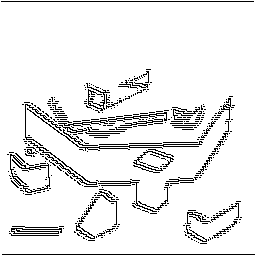

In [64]:
#test với ảnh mẫu

from PIL import Image as img

maTranAnh = img.open('images/input1.bmp').convert('RGB')
#maTranAnh = img.open('images/input2.gif').convert('RGB')
#maTranAnh = img.open('images/input4.jpg').convert('RGB')
m,n = maTranAnh.size
u = np.array(maTranAnh)[:,:,0]
print(u.shape)
u = u/255.0*2.0-1.0
ptvp.set_initial_value((u*0.0).flatten(), 0.0)
ptvp.set_f_params(u, testB, testA, testI, n, m)
x = (ptvp.integrate(cnn.t1))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output5.png')
print('done')
maTranAnh.show()
out

(795, 1080)
y = [[  0. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255.   0.]]
done


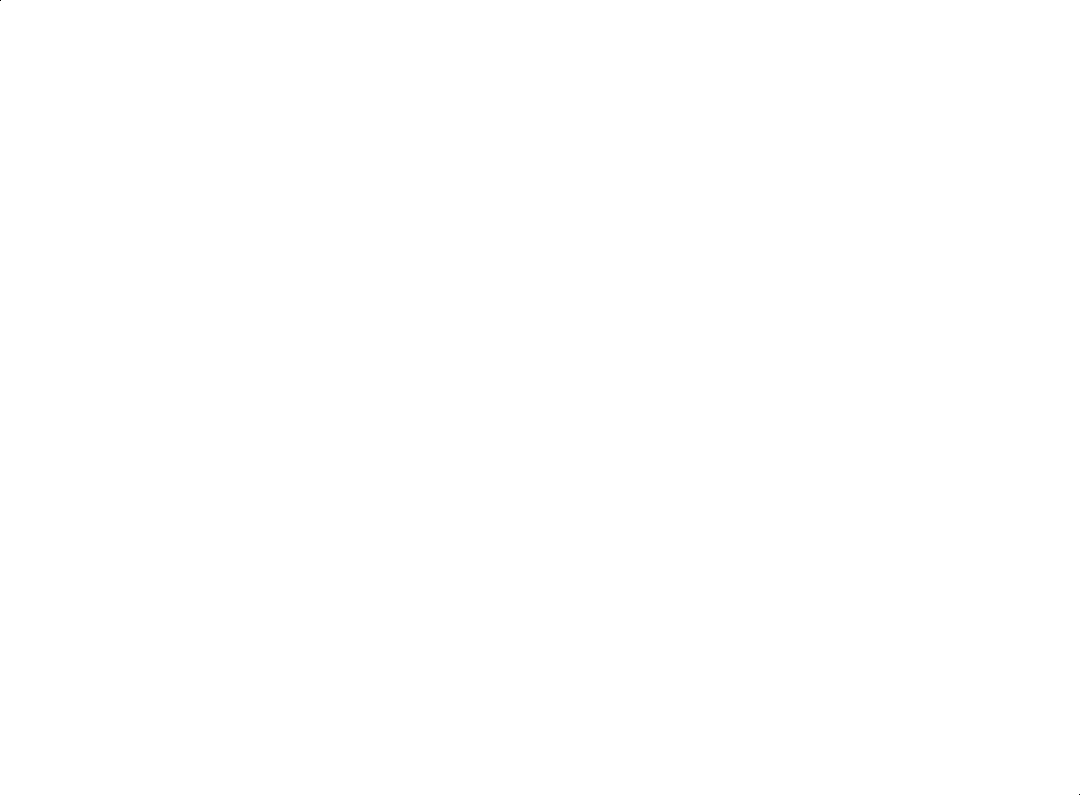

In [70]:
#test với ảnh kích thước lớn

#maTranAnh = img.open('images/input1.bmp').convert('RGB')
#maTranAnh = img.open('images/input2.gif').convert('RGB')
maTranAnh = img.open('images/input4.jpg').convert('RGB')
m,n = maTranAnh.size
u = np.sqrt(np.array(maTranAnh)[:,:,0]**2+np.array(maTranAnh)[:,:,1]**2+np.array(maTranAnh)[:,:,2]**2)
print(u.shape)
u = u/255.0/1.732*2.0-1.0
ptvp.set_initial_value((u*0.0).flatten(), 0.0)
ptvp.set_f_params(u, testB, testA, testI, n, m)
x = (ptvp.integrate(cnn.t1))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output9.png')
print('done')
maTranAnh.show()
out